## Imports

In [7]:
import matplotlib.pyplot as plt

import numpy as np
import torch

import os
import sys

sys.path.append(os.path.abspath('..'))

torch.cuda.empty_cache()

from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

from src.models.GaussianProcess import GaussianProcessRegressor, RBFKernel, RBFKernelIndependent

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#DEVICE = 'cpu'
DTYPE = torch.float64

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating Data

Out noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


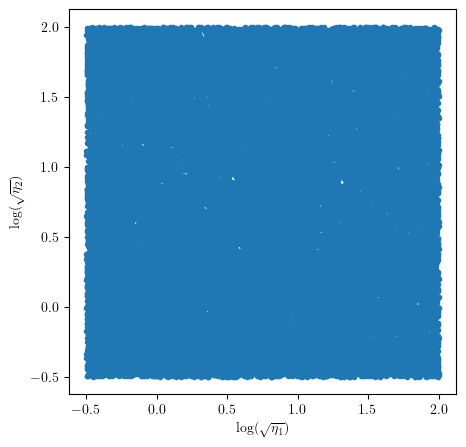

In [ ]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type="none", noise=0.0001)

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Data Sets and Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_train = torch.tensor(x_scaler.transform(etas_train), device=DEVICE, dtype=DTYPE)
y_train = torch.tensor(y_scaler.transform(gs_train), device=DEVICE, dtype=DTYPE)

x_test = torch.tensor(x_scaler.transform(etas_test), device=DEVICE, dtype=DTYPE)
y_test = torch.tensor(y_scaler.transform(gs_test), device=DEVICE, dtype=DTYPE)

## Training

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

trained_gps = []

load = False

if load:
    params = []
    for i in range(3):
        dict = pickle.load(open(f"../data/GP/D_LT_0/GP_chpc_LT_0/D_LT_0_{i}_KernelParams.pkl", "rb"))
        params.append(dict)

extra_a = [0.317, 0.5032, 0.4967]
extra_l = [2.1, 1.7, 1.73]

for i in range(y_train.shape[1]):
    if load:
        dict = params[i]
        print(dict)
        kernel = RBFKernel(length_scale=dict['length_scale'], amplitude=dict['amplitude'], device=DEVICE).to(DEVICE)
        #kernel = ConstantKernel(extra_a[i]**2, constant_value_bounds='fixed')*RBF(extra_l[i]/4, 'fixed')
    else:
        kernel = RBFKernel(length_scale=0.00001, amplitude=15.0, device=DEVICE).to(DEVICE)
        #kernel = 1.0*RBF(length_scale=.2, length_scale_bounds=(1e-3, 1e2))

    gp = GaussianProcessRegressor(kernel=kernel, noise=0.1, max_iter= 0 if load else 600, batch_size=3000, device=DEVICE, lr=1e-2, delta=1e-5)
    #gp = GPR(kernel=kernel, copy_X_train=False, n_restarts_optimizer=5)

    gp = gp.fit(x_train, y_train[:, i].unsqueeze(1))
    trained_gps.append(gp)
    print(gp.kernel.length_scale, gp.kernel.amplitude, gp.noise.cpu().detach().item())

for gp in trained_gps:
    print(gp.kernel.length_scale, gp.kernel.amplitude)
    #print(gp.kernel_)


#kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-6, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
#gp = gp.fit(x_train, y_train)

Iteration      0, Loss:    3629.23
Iteration     50, Loss:    3595.33
Iteration    100, Loss:    2393.31
Iteration    150, Loss:    2122.14
Iteration    200, Loss:    1957.26
Iteration    250, Loss:    1824.51
Iteration    300, Loss:    1707.61
Iteration    350, Loss:    1599.40
Iteration    400, Loss:    1495.81
Iteration    450, Loss:    1394.10
Iteration    500, Loss:    1292.13
Iteration    550, Loss:    1187.95
Parameter containing:
tensor(2.3590, device='cuda:0', requires_grad=True) Parameter containing:
tensor(8.2525, device='cuda:0', requires_grad=True) 0.0003021526208613068
Iteration      0, Loss:    3629.23
Iteration     50, Loss:    3595.33
Iteration    100, Loss:    2581.93
Iteration    150, Loss:    2152.57
Iteration    200, Loss:    1969.63
Iteration    250, Loss:    1829.79
Iteration    300, Loss:    1709.16
Iteration    350, Loss:    1598.70
Iteration    400, Loss:    1493.67
Iteration    450, Loss:    1391.00
Iteration    500, Loss:    1288.37
Iteration    550, Loss:  

## Plotting Samples

0.03454951910024621


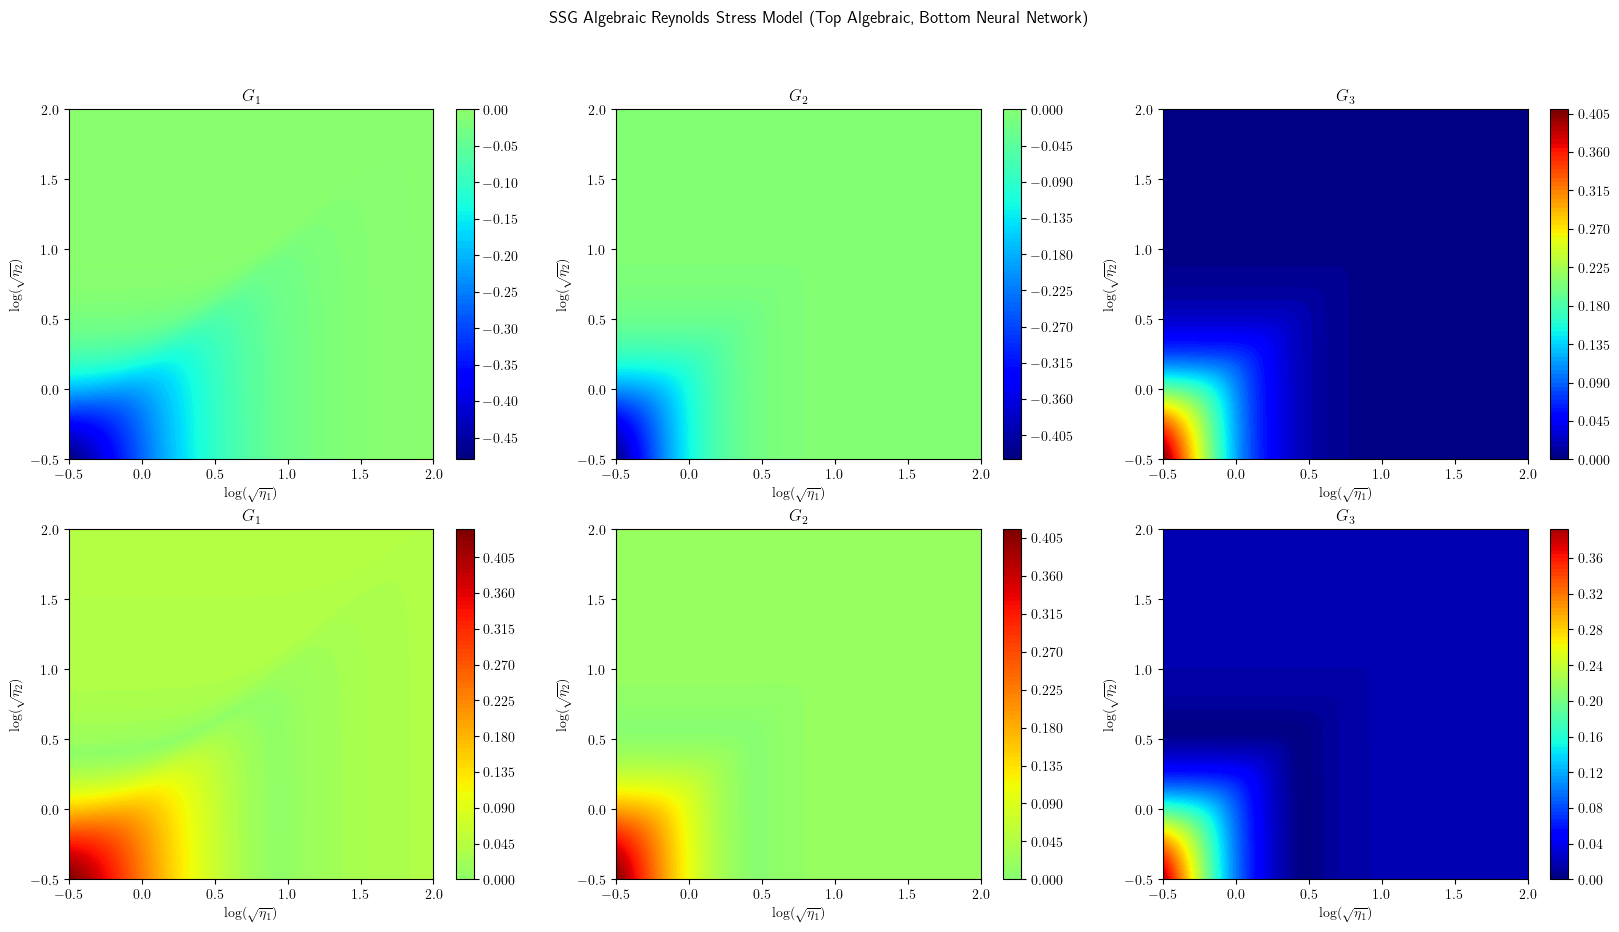

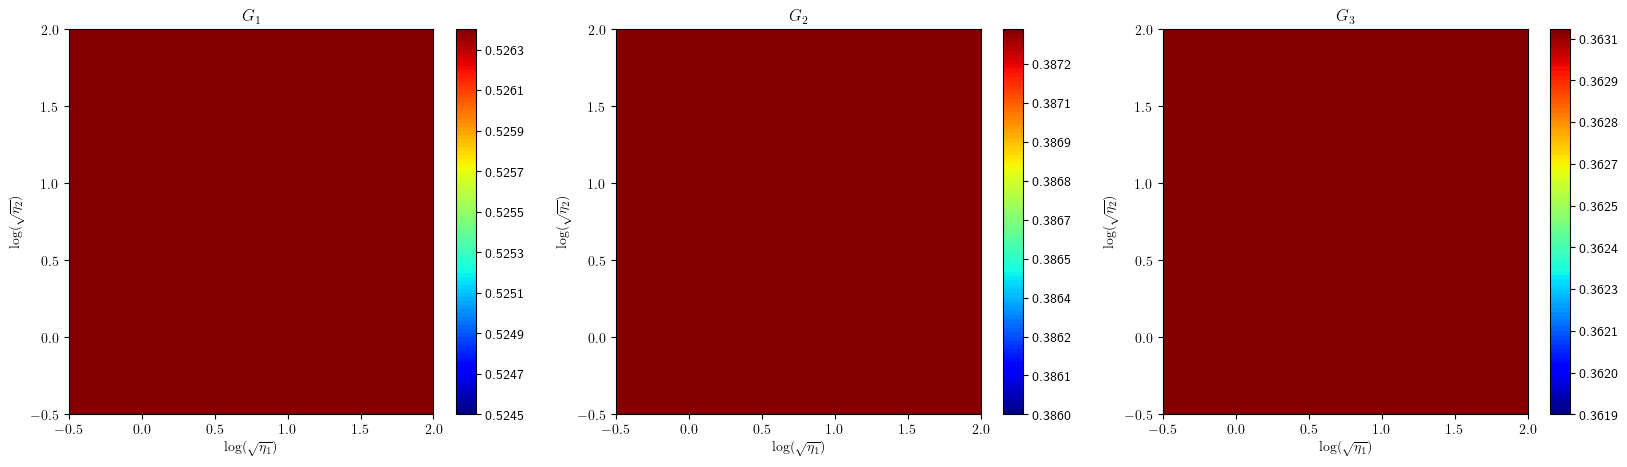

In [ ]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

etas = x_scaler.transform(etas)
etas = torch.tensor(etas, device=DEVICE, dtype=torch.float32)

pred_mean = []
pred_std = []

num_splits = 50

for x_split in np.array_split(etas, num_splits):
    pred_mean_split = np.zeros((x_split.shape[0], len(trained_gps)))
    pred_std_split = np.zeros((x_split.shape[0], len(trained_gps)))

    for i, gp in enumerate(trained_gps):
        pred, std = gp.predict(x_split, return_std=True)
        pred_mean_split[:, i], pred_std_split[:, i] = (pred.cpu().detach().squeeze().numpy(), std.cpu().detach().squeeze().numpy())
        #pred_mean_split[:, i], pred_std_split[:, i] = (pred, std)

    
    pred_mean.append(pred_mean_split)
    pred_std.append(pred_std_split)

pred_mean = np.concatenate(pred_mean, axis=0)
pred_std = np.concatenate(pred_std, axis=0)


pred_mean = y_scaler.inverse_transform(pred_mean)
pred_std = pred_std * y_scaler.scale_.reshape(1, -1)

print(np.mean(np.abs(target - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), np.abs(pred_mean-target).T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

## Output CHPC Result

### Getting test outputs for each sample

covar_module.raw_outputscale tensor([-0.3876])
covar_module.base_kernel.raw_lengthscale tensor([[[-0.5734, -0.6802]]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.0050)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(10.)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.0500)
covar_module.raw_outputscale_constraint.upper_bound tensor(20.)
likelihood.noise_covar.raw_noise tensor([-0.3754])
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-08)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(0.2000)
covar_module.raw_outputscale tensor([-0.5462])
covar_module.base_kernel.raw_lengthscale tensor([[[-0.8790, -0.8516]]])
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0.0050)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(10.)
covar_module.raw_outputscale_constraint.lower_bound tensor(0.0500)
covar_module.raw_outputscale_constraint.upper_bound tenso

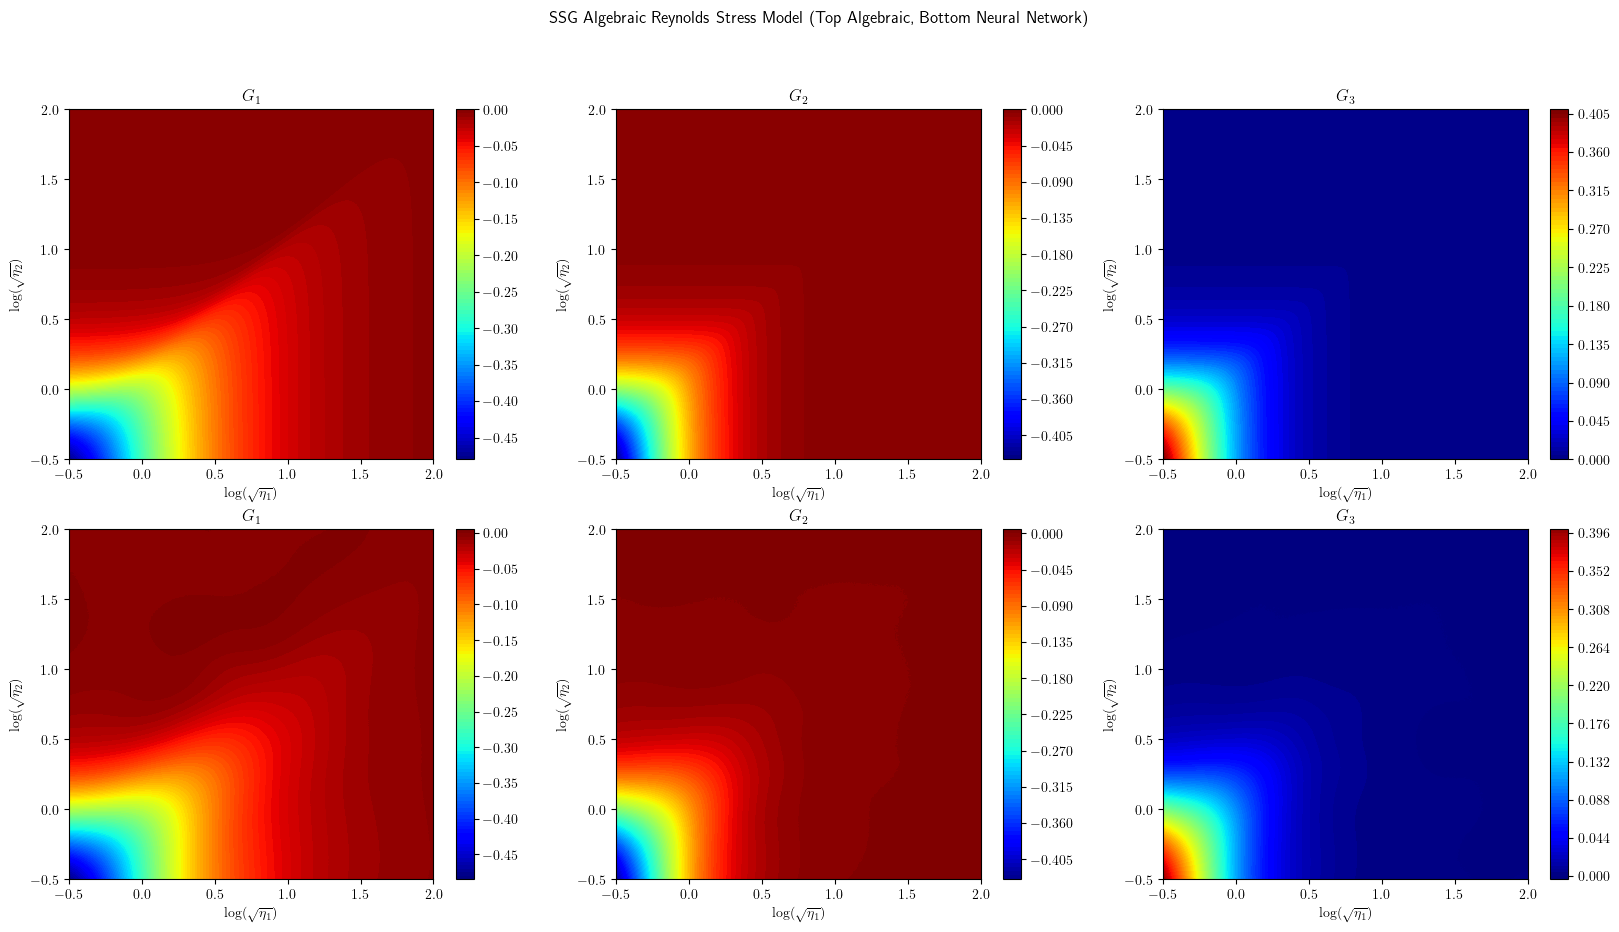

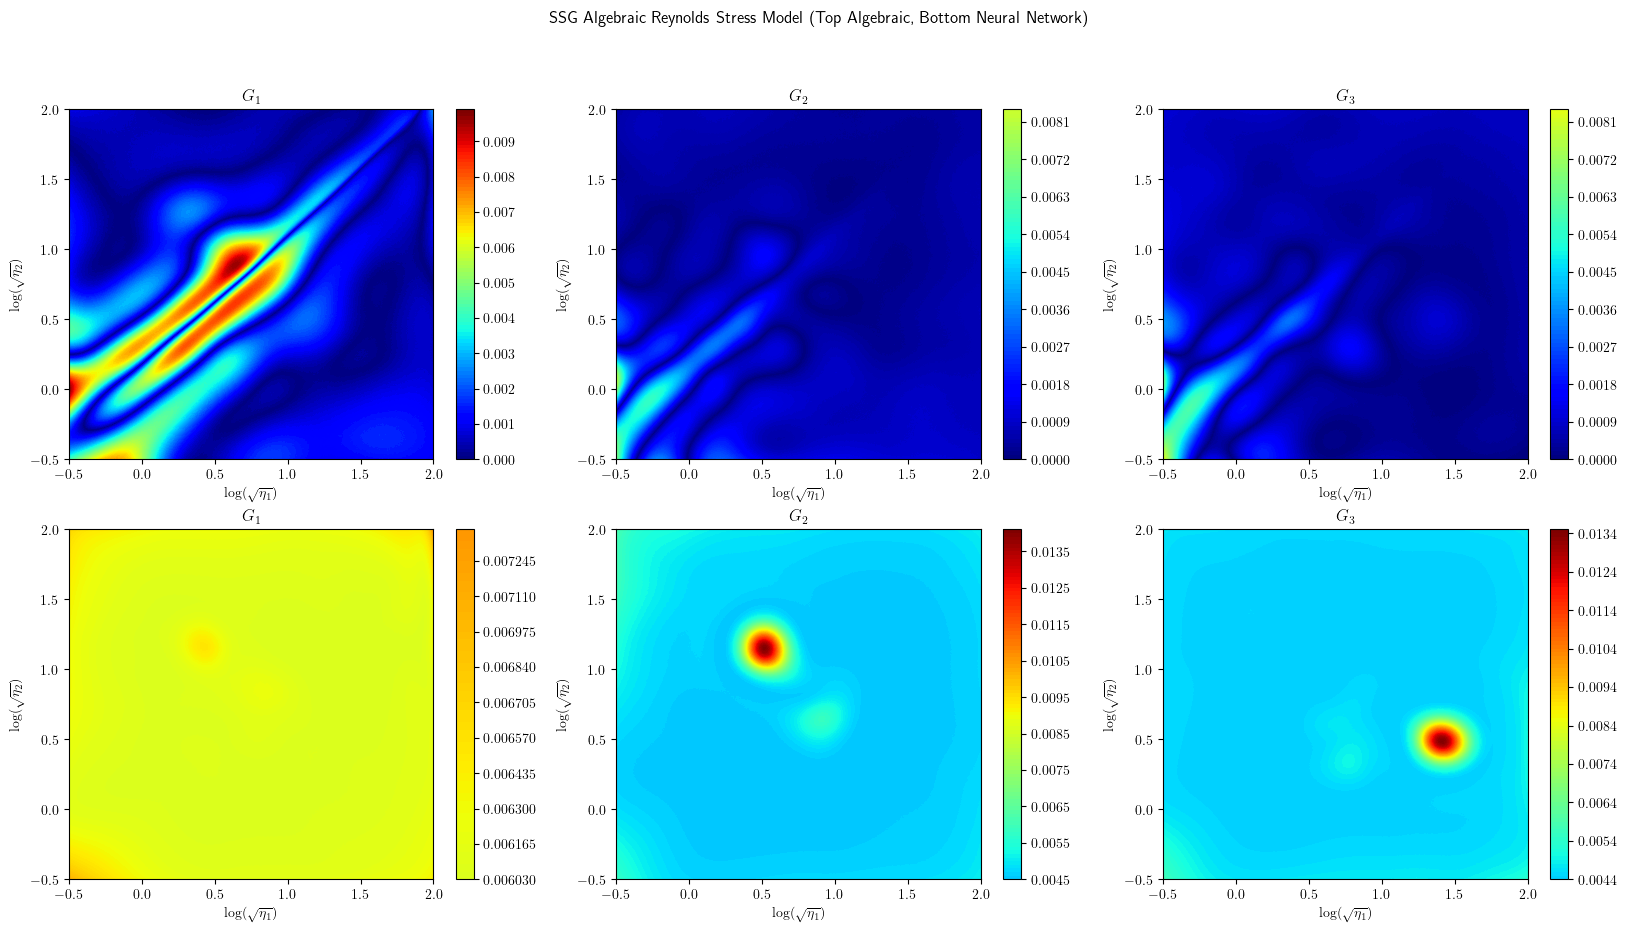

In [10]:
data_dir = "../data/GP_Pytorch/Regular_Alea_40k/"
save_prefix = "Regular_Alea_40k"
#data_dir = "../data/GP/GP_Full/"
#save_prefix = "Regular"

gpytorch = True

#data_dir = "../data/GP/"
#save_prefix = "GP_"

preds = []
stds = []
histories = []
alea_sigmas = []

for i in range(3):
    pred = np.load(data_dir + save_prefix + f"_Mean{i}.npy").reshape(-1,1)
    std = np.load(data_dir + save_prefix + f"_Std{i}.npy").reshape(-1,1)
    if gpytorch:
        kernel_dict = torch.load(data_dir + save_prefix + f"_{i}_Params.pt")
        for key in kernel_dict.keys():
            if "covar_module" in key or "likelihood" in key:
                print(key, kernel_dict[key])
        alea_sigmas.append(kernel_dict['likelihood.noise_covar.raw_noise'].item())  # Get the noise value from the likelihood
    else:
        kernel_dict = pickle.load(open(data_dir + save_prefix + f"_{i}_KernelParams.pkl", "rb"))
        print(kernel_dict)
        alea_sigmas.append(kernel_dict['noise'])
        histories.append(np.load(data_dir + save_prefix + f"_History_{i}.npy"))

    preds.append(pred)
    stds.append(std)

preds = np.concatenate(preds, axis=1)
stds = np.concatenate(stds, axis=1)
alea_sigmas = np.exp(np.array(alea_sigmas))*y_scaler.scale_  # Ensure the sigmas are scaled correctly

print(preds.shape)
print(stds.shape)

print(stds.max(0))

np.savetxt(data_dir + save_prefix + "_Sigmas.csv", alea_sigmas, delimiter=",")
np.savetxt(data_dir + save_prefix + "_Pred_Mean.csv", preds, delimiter=",")
np.savetxt(data_dir + save_prefix + "_Pred_Std.csv", stds, delimiter=",")

dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

if gpytorch:
    print(np.mean(np.abs(G_s - preds)))

    plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), preds.T.reshape(3, dim, dim))

    plot_heat_map_compare(x_grid, y_grid, np.abs(preds.T.reshape(3, dim, dim) - G_s.T.reshape(3, dim, dim)), stds.T.reshape(3, dim, dim))
else:
    print(np.mean(np.abs(G_s - preds)))

    plot_heat_map_compare(x_grid, y_grid, G_s.T.reshape(3, dim, dim), np.abs(preds.T.reshape(3, dim, dim) - G_s.T.reshape(3, dim, dim)))

    plot_heat_map_3D(x_grid, y_grid, stds.T.reshape(3, dim, dim))

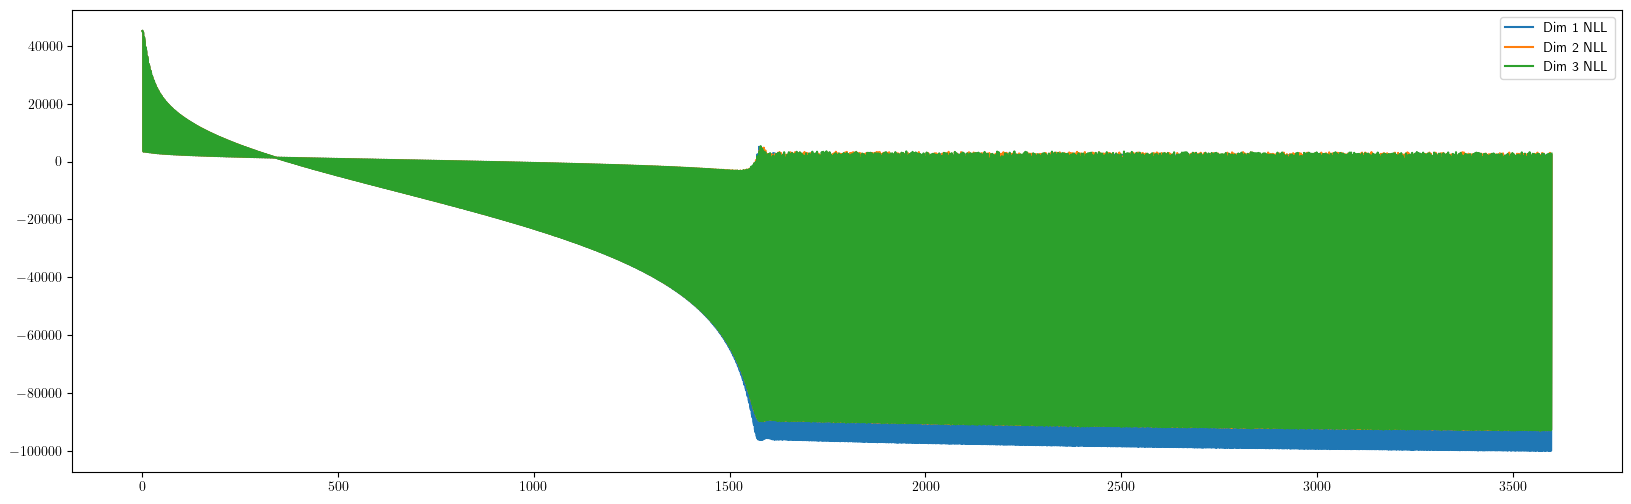

In [6]:
plt_1 = plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(histories[0])), histories[0], label="Dim 1 NLL")
plt.plot(np.arange(len(histories[1])), histories[1], label="Dim 2 NLL")
plt.plot(np.arange(len(histories[2])), histories[2], label="Dim 3 NLL")

plt.legend()
plt.show()

In [ ]:
d_dir = "../data/GP/GPTEST/"

param_dict = torch.load(d_dir + "GPYTORCH_0_Params.pt")